# LSRTM modelo personalizado

In [2]:
using PyPlot, JLD, SegyIO, JUDI, SlimOptim, Statistics, Random, LinearAlgebra, HDF5, Dates, DelimitedFiles

In [3]:
n,d,o,m,m0 = read(h5open("$(JUDI.JUDI_DATA)/overthrust_model.h5","r"), "n", "d", "o", "m", "m0");
dm = m - m0;

In [4]:
model0 = Model((n[1],n[2]), (d[1],d[2]), (o[1],o[2]), m0)

block = segy_read("model_overthrust_high_f_lin.segy")
dD = judiVector(block);

# Set up wavelet
src_geometry = Geometry(block; key="source", segy_depth_key="SourceDepth")
wavelet = ricker_wavelet(src_geometry.t[1],src_geometry.dt[1],0.008)	# 4 Hz wavelet
q = judiVector(src_geometry,wavelet)

# Set up info structure
ntComp = get_computational_nt(q.geometry,dD.geometry,model0)	# no. of computational time steps
info = Info(prod(model0.n),dD.nsrc,ntComp);

┌ Warning: Fixed length trace flag set in stream: IOBuffer(data=UInt8[...], readable=true, writable=false, seekable=true, append=false, size=7220304, maxsize=Inf, ptr=3601, mark=-1)
└ @ SegyIO /home/geopc3/.julia/packages/SegyIO/aQwou/src/read/read_file.jl:36


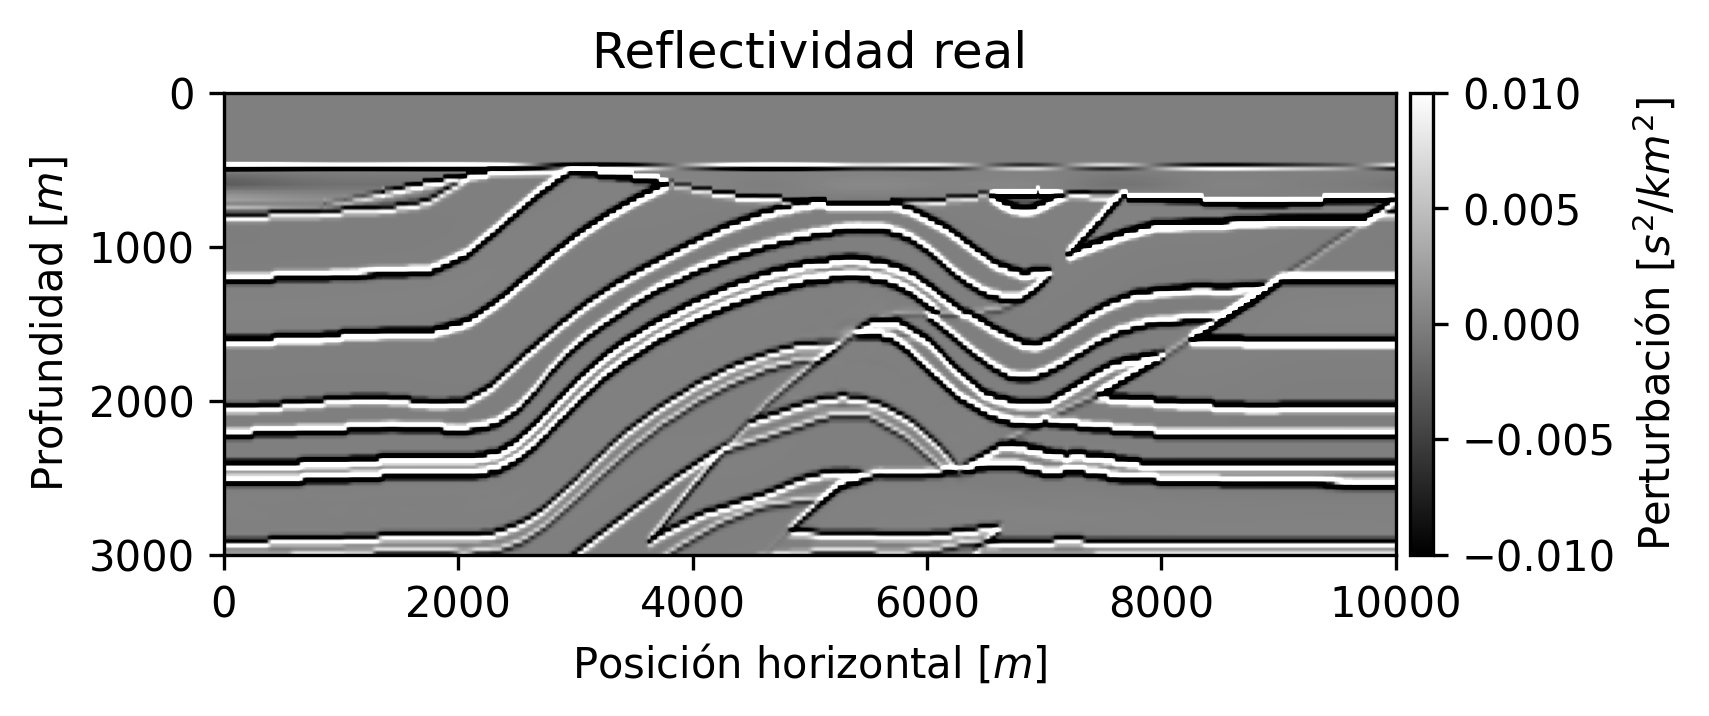

In [105]:
dm_ = diff(reshape(dm, (401,121)), dims=2);

fig = figure(figsize=(6,2), dpi=300);
im = imshow(diff(dm_, dims=2)', cmap="gray", extent=[0, (model0.n[1]-1)*model0.d[1], (model0.n[2]-1)*model0.d[2], 0], vmin=-.01, vmax=.01, aspect="auto")
cb = colorbar(im, pad=0.01)
cb[:set_label](label = L"Perturbación $[s^2/km^2]$")
xlabel(L"Posición horizontal $[m]$")
ylabel(L"Profundidad $[m]$")
title("Reflectividad real")
display(fig)

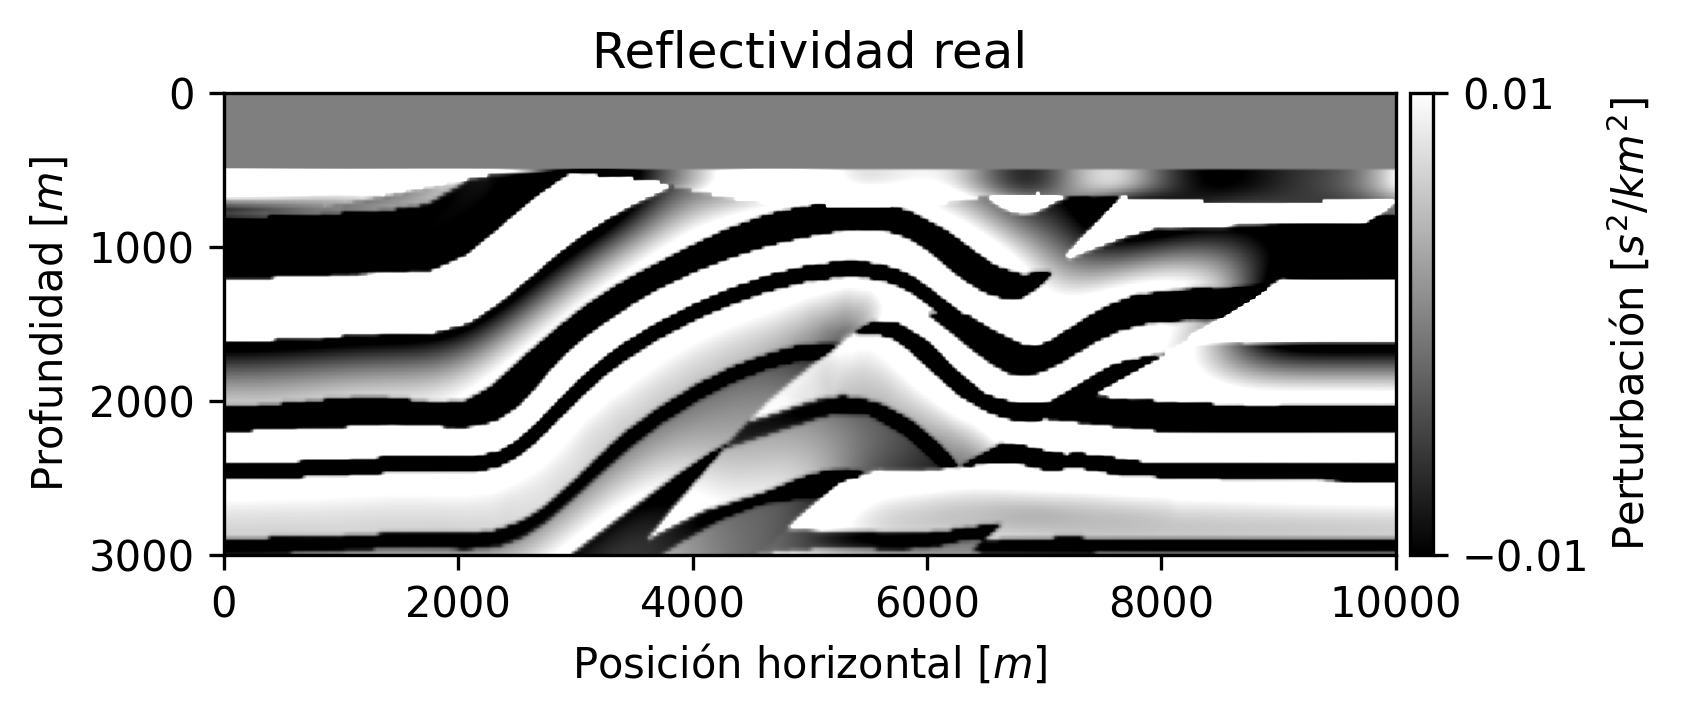

In [77]:
fig = figure(figsize=(6,2), dpi=300);
im = imshow(reshape(dm, (401,121))', cmap="gray", extent=[0, (model0.n[1]-1)*model0.d[1], (model0.n[2]-1)*model0.d[2], 0], vmin=-.01, vmax=.01, aspect="auto")
cb = colorbar(im, ticks=-0.05:0.02:0.05, pad=0.01)
cb[:set_label](label = L"Perturbación $[s^2/km^2]$")
xlabel(L"Posición horizontal $[m]$")
ylabel(L"Profundidad $[m]$")
title("Reflectividad real")
display(fig)

In [10]:
# Set up matrix-free linear operators
opt = Options(optimal_checkpointing = true)    # set to false to disable optimal checkpointing
F = judiModeling(model0, q.geometry, dD.geometry; options=opt)
J = judiJacobian(F, q);

# Right-hand preconditioners (model topmute)
Mr = judiTopmute(model0; taperwidth=2)	# mute up to grid point 52, with 10 point taper
# Left-hand side preconditioners
Ml = judiDataMute(q.geometry, dD.geometry; t0=.120);	# data topmute starting at time 120ms

In [11]:
rtm = adjoint(J)*dD

Building forward operator
/home/geopc3/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/geopc3/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
Building adjoint born operator


PhysicalParameter{Float32} of size (401, 121) with origin (0.0, 0.0) and spacing (25.0, 25.0)


In [12]:
# Stochastic gradient
x = zeros(Float32, info.n)	# zero initial guess
batchsize = 10	# use subset of 10 shots per iteration
niter = 30
fval = zeros(Float32, niter) # misfit value
x_values = zeros(length(x), niter+1) # image iteration results
x_values[:, 1] = x
t1 = now()
for j=1:niter
	println("Iteration: ", j)
	# Select batch and set up left-hand preconditioner
	i = randperm(dD.nsrc)[1:batchsize]

	# Compute residual and gradient
	r = Ml[i]*J[i]*Mr*x - Ml[i]*dD[i]
	g = adjoint(Mr)*adjoint(J[i])*adjoint(Ml[i])*r

	# Step size and update variable
	fval[j] = .5f0*norm(r)^2
	t = norm(r)^2/norm(g)^2
	global x -= t*g
	x_values[:, j+1] = x # save updated x to array
end
t2 = now()

Iteration: 1
Iteration: 

2


┌ Warning: JOLI linear operator, returning julia Array
└ @ JUDI /home/geopc3/.julia/packages/JUDI/DUfUj/src/TimeModeling/Types/ModelStructure.jl:191
Building born operator
Operator `born` ran in 0.06 s
Operator `born` ran in 0.09 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.06 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.07 s


Iteration: 3


┌ Warning: JOLI linear operator, returning julia Array
└ @ JUDI /home/geopc3/.julia/packages/JUDI/DUfUj/src/TimeModeling/Types/ModelStructure.jl:191
Operator `born` ran in 0.07 s
Operator `born` ran in 0.09 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.09 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.09 s
Operator `born` ran in 0.09 s


Iteration: 4


┌ Warning: JOLI linear operator, returning julia Array
└ @ JUDI /home/geopc3/.julia/packages/JUDI/DUfUj/src/TimeModeling/Types/ModelStructure.jl:191
Operator `born` ran in 0.07 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.09 s
Operator `born` ran in 0.09 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.09 s


Iteration: 5


┌ Warning: JOLI linear operator, returning julia Array
└ @ JUDI /home/geopc3/.julia/packages/JUDI/DUfUj/src/TimeModeling/Types/ModelStructure.jl:191
Operator `born` ran in 0.06 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.06 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.06 s
Operator `born` ran in 0.06 s
Operator `born` ran in 0.06 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.06 s
Operator `born` ran in 0.06 s


Iteration: 6


┌ Warning: JOLI linear operator, returning julia Array
└ @ JUDI /home/geopc3/.julia/packages/JUDI/DUfUj/src/TimeModeling/Types/ModelStructure.jl:191
Operator `born` ran in 0.07 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.06 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.06 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.06 s
Operator `born` ran in 0.06 s
Operator `born` ran in 0.06 s


Iteration: 7


┌ Warning: JOLI linear operator, returning julia Array
└ @ JUDI /home/geopc3/.julia/packages/JUDI/DUfUj/src/TimeModeling/Types/ModelStructure.jl:191
Operator `born` ran in 0.06 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.06 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.06 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.06 s
Operator `born` ran in 0.07 s


Iteration: 8


┌ Warning: JOLI linear operator, returning julia Array
└ @ JUDI /home/geopc3/.julia/packages/JUDI/DUfUj/src/TimeModeling/Types/ModelStructure.jl:191
Operator `born` ran in 0.06 s
Operator `born` ran in 0.06 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.06 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.06 s


Iteration: 9


┌ Warning: JOLI linear operator, returning julia Array
└ @ JUDI /home/geopc3/.julia/packages/JUDI/DUfUj/src/TimeModeling/Types/ModelStructure.jl:191
Operator `born` ran in 0.06 s
Operator `born` ran in 0.06 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.06 s
Operator `born` ran in 0.06 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.06 s
Operator `born` ran in 0.06 s
Operator `born` ran in 0.07 s


Iteration: 10


┌ Warning: JOLI linear operator, returning julia Array
└ @ JUDI /home/geopc3/.julia/packages/JUDI/DUfUj/src/TimeModeling/Types/ModelStructure.jl:191
Operator `born` ran in 0.07 s
Operator `born` ran in 0.09 s
Operator `born` ran in 0.06 s
Operator `born` ran in 0.06 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.06 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.06 s
Operator `born` ran in 0.07 s


Iteration: 11


┌ Warning: JOLI linear operator, returning julia Array
└ @ JUDI /home/geopc3/.julia/packages/JUDI/DUfUj/src/TimeModeling/Types/ModelStructure.jl:191
Operator `born` ran in 0.06 s
Operator `born` ran in 0.06 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.06 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.06 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.06 s


Iteration: 12


┌ Warning: JOLI linear operator, returning julia Array
└ @ JUDI /home/geopc3/.julia/packages/JUDI/DUfUj/src/TimeModeling/Types/ModelStructure.jl:191
Operator `born` ran in 0.06 s
Operator `born` ran in 0.06 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.06 s
Operator `born` ran in 0.06 s
Operator `born` ran in 0.06 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.06 s


Iteration: 13


┌ Warning: JOLI linear operator, returning julia Array
└ @ JUDI /home/geopc3/.julia/packages/JUDI/DUfUj/src/TimeModeling/Types/ModelStructure.jl:191
Operator `born` ran in 0.06 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.06 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.06 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.06 s
Operator `born` ran in 0.07 s


Iteration: 14


┌ Warning: JOLI linear operator, returning julia Array
└ @ JUDI /home/geopc3/.julia/packages/JUDI/DUfUj/src/TimeModeling/Types/ModelStructure.jl:191
Operator `born` ran in 0.06 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.06 s
Operator `born` ran in 0.06 s
Operator `born` ran in 0.09 s
Operator `born` ran in 0.06 s
Operator `born` ran in 0.06 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.07 s


Iteration: 15


┌ Warning: JOLI linear operator, returning julia Array
└ @ JUDI /home/geopc3/.julia/packages/JUDI/DUfUj/src/TimeModeling/Types/ModelStructure.jl:191
Operator `born` ran in 0.06 s
Operator `born` ran in 0.06 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.06 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.07 s


Iteration: 16


┌ Warning: JOLI linear operator, returning julia Array
└ @ JUDI /home/geopc3/.julia/packages/JUDI/DUfUj/src/TimeModeling/Types/ModelStructure.jl:191
Operator `born` ran in 0.06 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.06 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.06 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.07 s


Iteration: 17


┌ Warning: JOLI linear operator, returning julia Array
└ @ JUDI /home/geopc3/.julia/packages/JUDI/DUfUj/src/TimeModeling/Types/ModelStructure.jl:191
Operator `born` ran in 0.06 s
Operator `born` ran in 0.06 s
Operator `born` ran in 0.06 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.06 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.06 s
Operator `born` ran in 0.07 s


Iteration: 18


┌ Warning: JOLI linear operator, returning julia Array
└ @ JUDI /home/geopc3/.julia/packages/JUDI/DUfUj/src/TimeModeling/Types/ModelStructure.jl:191
Operator `born` ran in 0.06 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.09 s
Operator `born` ran in 0.09 s
Operator `born` ran in 0.09 s
Operator `born` ran in 0.09 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.06 s


Iteration: 19


┌ Warning: JOLI linear operator, returning julia Array
└ @ JUDI /home/geopc3/.julia/packages/JUDI/DUfUj/src/TimeModeling/Types/ModelStructure.jl:191
Operator `born` ran in 0.06 s
Operator `born` ran in 0.05 s
Operator `born` ran in 0.06 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.06 s
Operator `born` ran in 0.07 s


Iteration: 20


┌ Warning: JOLI linear operator, returning julia Array
└ @ JUDI /home/geopc3/.julia/packages/JUDI/DUfUj/src/TimeModeling/Types/ModelStructure.jl:191
Operator `born` ran in 0.06 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.06 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.07 s


Iteration: 21


┌ Warning: JOLI linear operator, returning julia Array
└ @ JUDI /home/geopc3/.julia/packages/JUDI/DUfUj/src/TimeModeling/Types/ModelStructure.jl:191
Operator `born` ran in 0.06 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.06 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.06 s


Iteration: 22


┌ Warning: JOLI linear operator, returning julia Array
└ @ JUDI /home/geopc3/.julia/packages/JUDI/DUfUj/src/TimeModeling/Types/ModelStructure.jl:191
Operator `born` ran in 0.06 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.06 s
Operator `born` ran in 0.06 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.07 s


Iteration: 23


┌ Warning: JOLI linear operator, returning julia Array
└ @ JUDI /home/geopc3/.julia/packages/JUDI/DUfUj/src/TimeModeling/Types/ModelStructure.jl:191
Operator `born` ran in 0.06 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.08 s


Iteration: 24


┌ Warning: JOLI linear operator, returning julia Array
└ @ JUDI /home/geopc3/.julia/packages/JUDI/DUfUj/src/TimeModeling/Types/ModelStructure.jl:191
Operator `born` ran in 0.06 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.06 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.06 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.06 s
Operator `born` ran in 0.07 s


Iteration: 25


┌ Warning: JOLI linear operator, returning julia Array
└ @ JUDI /home/geopc3/.julia/packages/JUDI/DUfUj/src/TimeModeling/Types/ModelStructure.jl:191
Operator `born` ran in 0.06 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.05 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.07 s


Iteration: 26


┌ Warning: JOLI linear operator, returning julia Array
└ @ JUDI /home/geopc3/.julia/packages/JUDI/DUfUj/src/TimeModeling/Types/ModelStructure.jl:191
Operator `born` ran in 0.06 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.09 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.06 s
Operator `born` ran in 0.09 s
Operator `born` ran in 0.08 s


Iteration: 27


┌ Warning: JOLI linear operator, returning julia Array
└ @ JUDI /home/geopc3/.julia/packages/JUDI/DUfUj/src/TimeModeling/Types/ModelStructure.jl:191
Operator `born` ran in 0.06 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.09 s
Operator `born` ran in 0.09 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.06 s
Operator `born` ran in 0.07 s


Iteration: 28


┌ Warning: JOLI linear operator, returning julia Array
└ @ JUDI /home/geopc3/.julia/packages/JUDI/DUfUj/src/TimeModeling/Types/ModelStructure.jl:191
Operator `born` ran in 0.06 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.06 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.06 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.06 s
Operator `born` ran in 0.06 s


Iteration: 29


┌ Warning: JOLI linear operator, returning julia Array
└ @ JUDI /home/geopc3/.julia/packages/JUDI/DUfUj/src/TimeModeling/Types/ModelStructure.jl:191
Operator `born` ran in 0.06 s
Operator `born` ran in 0.06 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.06 s


Iteration: 30


┌ Warning: JOLI linear operator, returning julia Array
└ @ JUDI /home/geopc3/.julia/packages/JUDI/DUfUj/src/TimeModeling/Types/ModelStructure.jl:191
Operator `born` ran in 0.06 s
Operator `born` ran in 0.06 s
Operator `born` ran in 0.05 s
Operator `born` ran in 0.06 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.06 s
Operator `born` ran in 0.07 s
Operator `born` ran in 0.08 s
Operator `born` ran in 0.07 s


2023-09-03T01:21:29.569

In [13]:
t2-t1

950717 milliseconds

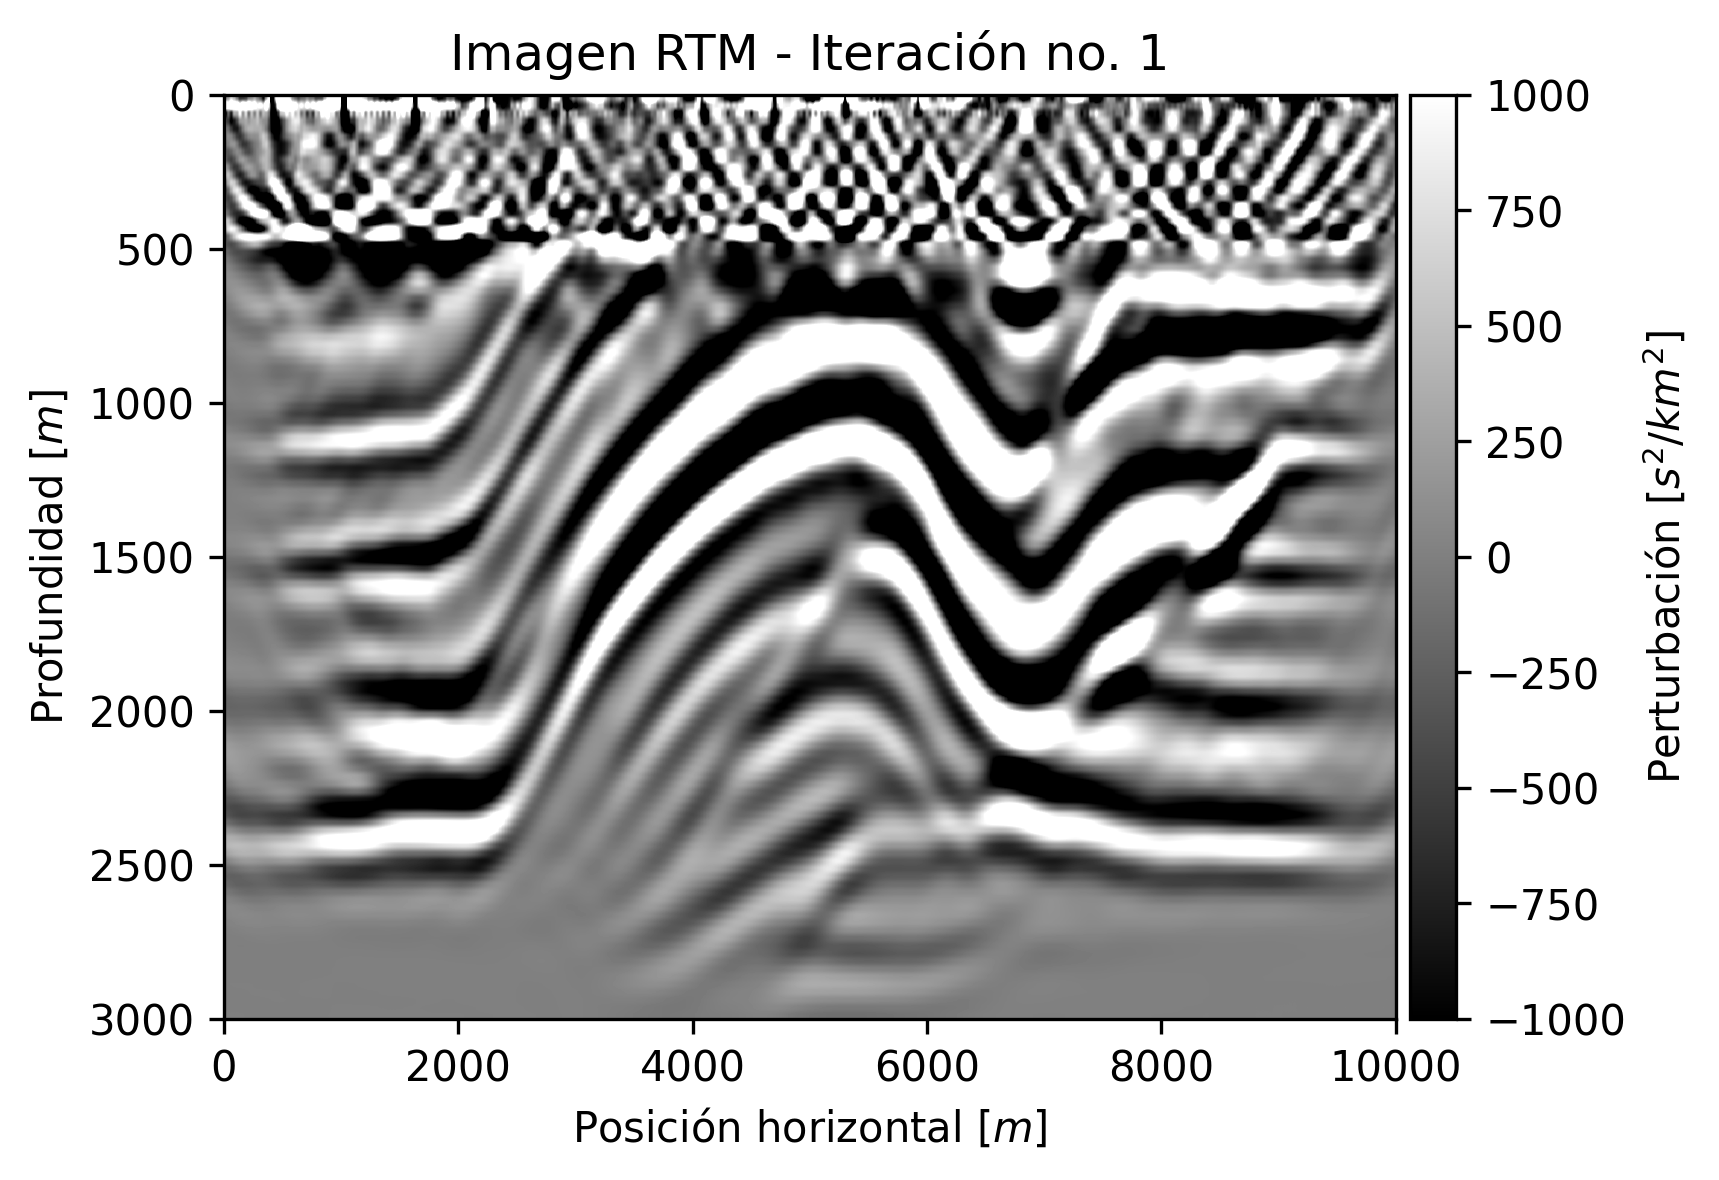

In [93]:
fig=figure(figsize=(6,4), dpi=300);
im = imshow(diff(rtm.data, dims=2)', vmin=-1e3, vmax=1e3, cmap="gray", extent=[0, (model0.n[1]-1)*model0.d[1], (model0.n[2]-1)*model0.d[2], 0], aspect="auto")
cb = colorbar(im, pad=0.01)
cb[:set_label](label = L"Perturbación $[s^2/km^2]$")
xlabel(L"Posición horizontal $[m]$")
ylabel(L"Profundidad $[m]$")
title("Imagen RTM - Iteración no. 1")
display(fig)
#savefig("lsrtm/lsrtm1.jpeg",format="jpeg");

In [10]:
for a=1:32
    fig=figure(figsize=(7,4), dpi=300);
    if a <=2
        im = imshow(diff(rtm.data, dims=2)', vmin=-1e3, vmax=1e3, cmap="gray", extent=[0, (model0.n[1]-1)*model0.d[1], (model0.n[2]-1)*model0.d[2], 0], aspect="auto")
        title("RTM")
    else
        im = imshow(diff(reshape(x_values[:, a-1], (401,121)), dims=2)', vmin=-.01, vmax=.01, cmap="gray", extent=[0, (model0.n[1]-1)*model0.d[1], (model0.n[2]-1)*model0.d[2], 0], aspect="auto")
        title("LSRTM - iteración:"*string(a-2))
    end
    cb = colorbar(im, pad=0.01)
    cb[:set_label](label = L"Perturbación $[s^2/km^2]$")
    xlabel(L"Posición horizontal $[m]$")
    ylabel(L"Profundidad $[m]$")
    savefig("lsrtm_results/lsrtm"*string(a)*".jpeg",format="jpeg", dpi=300);
    plt.close()
end

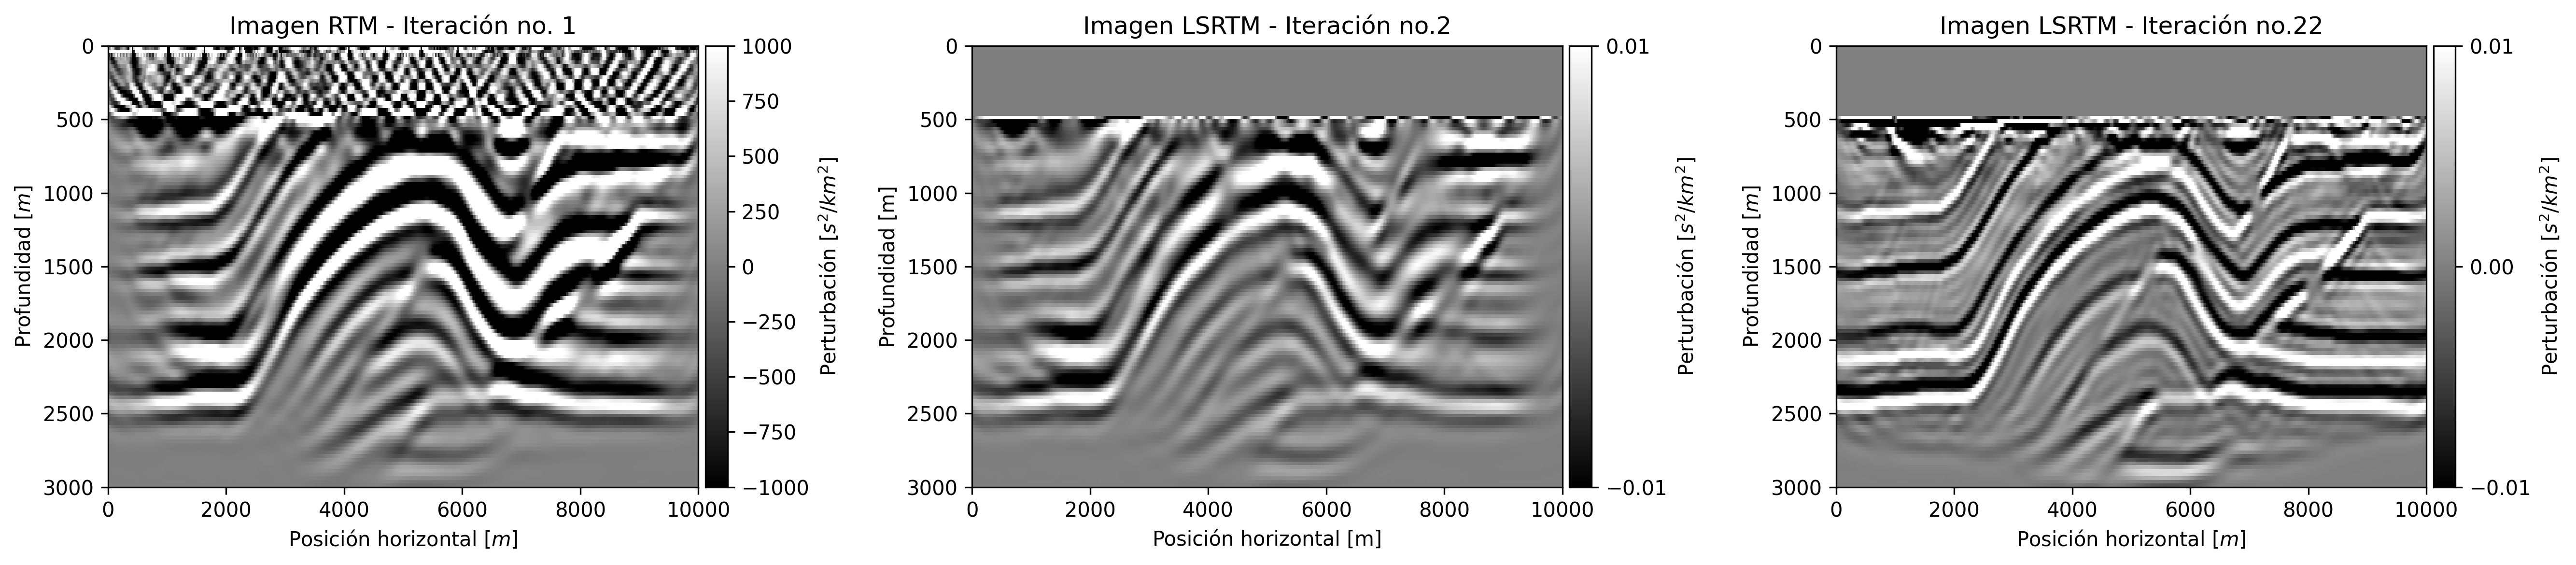

In [109]:
fig=figure(figsize=(18,4), dpi=300); #, dpi=300
subplot(131)
im = imshow(diff(rtm.data, dims=2)', vmin=-1e3, vmax=1e3, cmap="gray", extent=[0, (model0.n[1]-1)*model0.d[1], (model0.n[2]-1)*model0.d[2], 0], aspect="auto")
cb = colorbar(im, pad=0.01)
cb[:set_label](label = L"Perturbación $[s^2/km^2]$")
xlabel(L"Posición horizontal $[m]$")
ylabel(L"Profundidad $[m]$")
title("Imagen RTM - Iteración no. 1")
subplot(132)
im = imshow(diff(reshape(x_values[:, 2], (401,121)), dims=2)', vmin=-.01, vmax=.01, cmap="gray", extent=[0, (model0.n[1]-1)*model0.d[1], (model0.n[2]-1)*model0.d[2], 0], aspect="auto")
cb = colorbar(im, pad=0.01, ticks=-0.05:0.02:0.05)
cb[:set_label](label = L"Perturbación $[s^2/km^2]$")
xlabel("Posición horizontal [m]")
ylabel("Profundidad [m]")
title("Imagen LSRTM - Iteración no.2")
subplot(133)
im = imshow(diff(reshape(x_values[:, 31], (401,121)), dims=2)', vmin=-.01, vmax=.01, cmap="gray", extent=[0, (model0.n[1]-1)*model0.d[1], (model0.n[2]-1)*model0.d[2], 0], aspect="auto")
cb = colorbar(im, pad=0.01, ticks=-0.01:0.01:0.01)
cb[:set_label](label = L"Perturbación $[s^2/km^2]$")
xlabel(L"Posición horizontal $[m]$")
ylabel(L"Profundidad $[m]$")
title("Imagen LSRTM - Iteración no.22")
tight_layout()
display(fig)

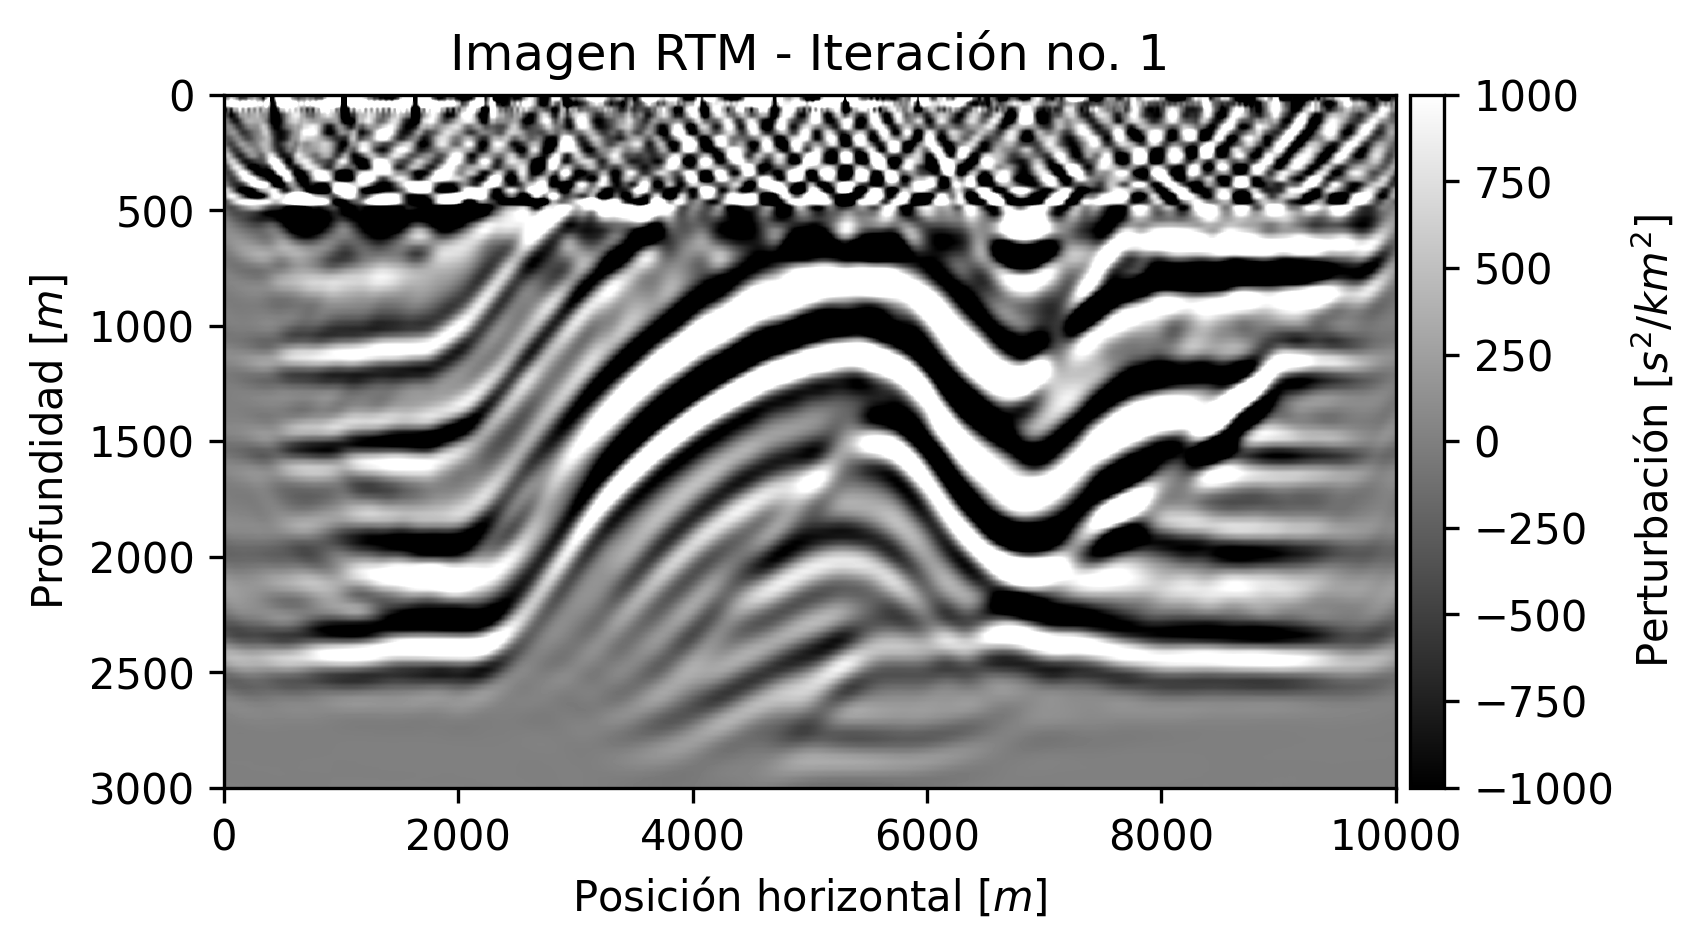

In [101]:
fig=figure(figsize=(6,3), dpi=300);
im = imshow(diff(rtm.data, dims=2)', vmin=-1e3, vmax=1e3, cmap="gray", extent=[0, (model0.n[1]-1)*model0.d[1], (model0.n[2]-1)*model0.d[2], 0], aspect="auto")
cb = colorbar(im, pad=0.01)
cb[:set_label](label = L"Perturbación $[s^2/km^2]$")
xlabel(L"Posición horizontal $[m]$")
ylabel(L"Profundidad $[m]$")
title("Imagen RTM - Iteración no. 1")
display(fig)

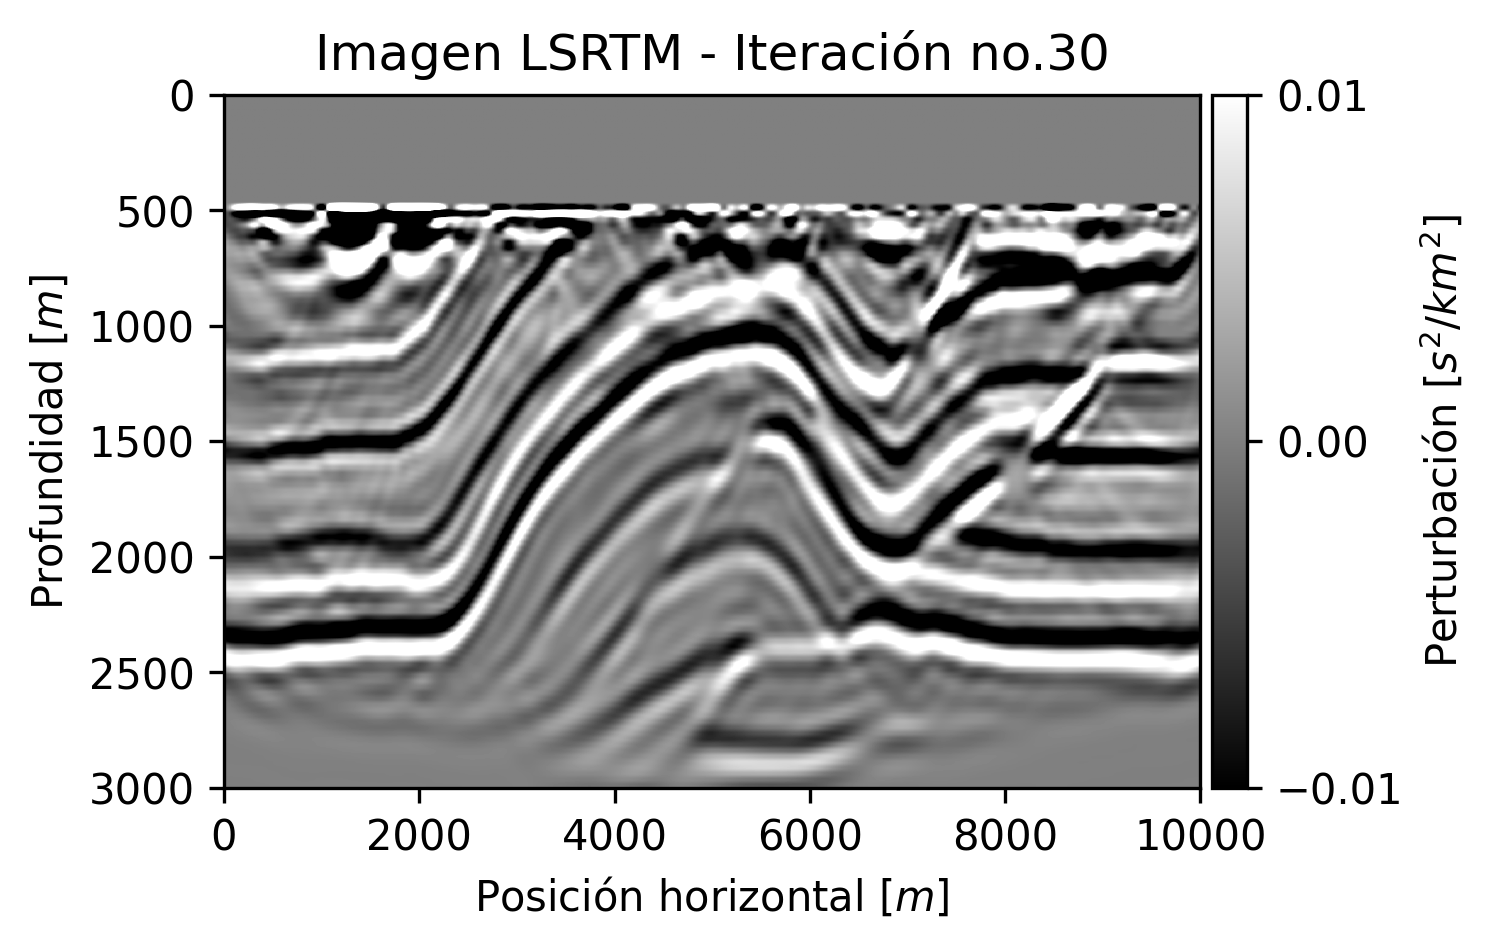

In [108]:
fig=figure(figsize=(5,3), dpi=300);
im = imshow(diff(reshape(x_values[:, 23], (401,121)), dims=2)', vmin=-.01, vmax=.01, cmap="gray", extent=[0, (model0.n[1]-1)*model0.d[1], (model0.n[2]-1)*model0.d[2], 0], aspect="auto")
cb = colorbar(im, pad=0.01, ticks=-0.01:0.01:0.01)
cb[:set_label](label = L"Perturbación $[s^2/km^2]$")
xlabel(L"Posición horizontal $[m]$")
ylabel(L"Profundidad $[m]$")
title("Imagen LSRTM - Iteración no.30")
display(fig)

In [16]:
fhistory_SGD = fval/norm(fval, Inf);

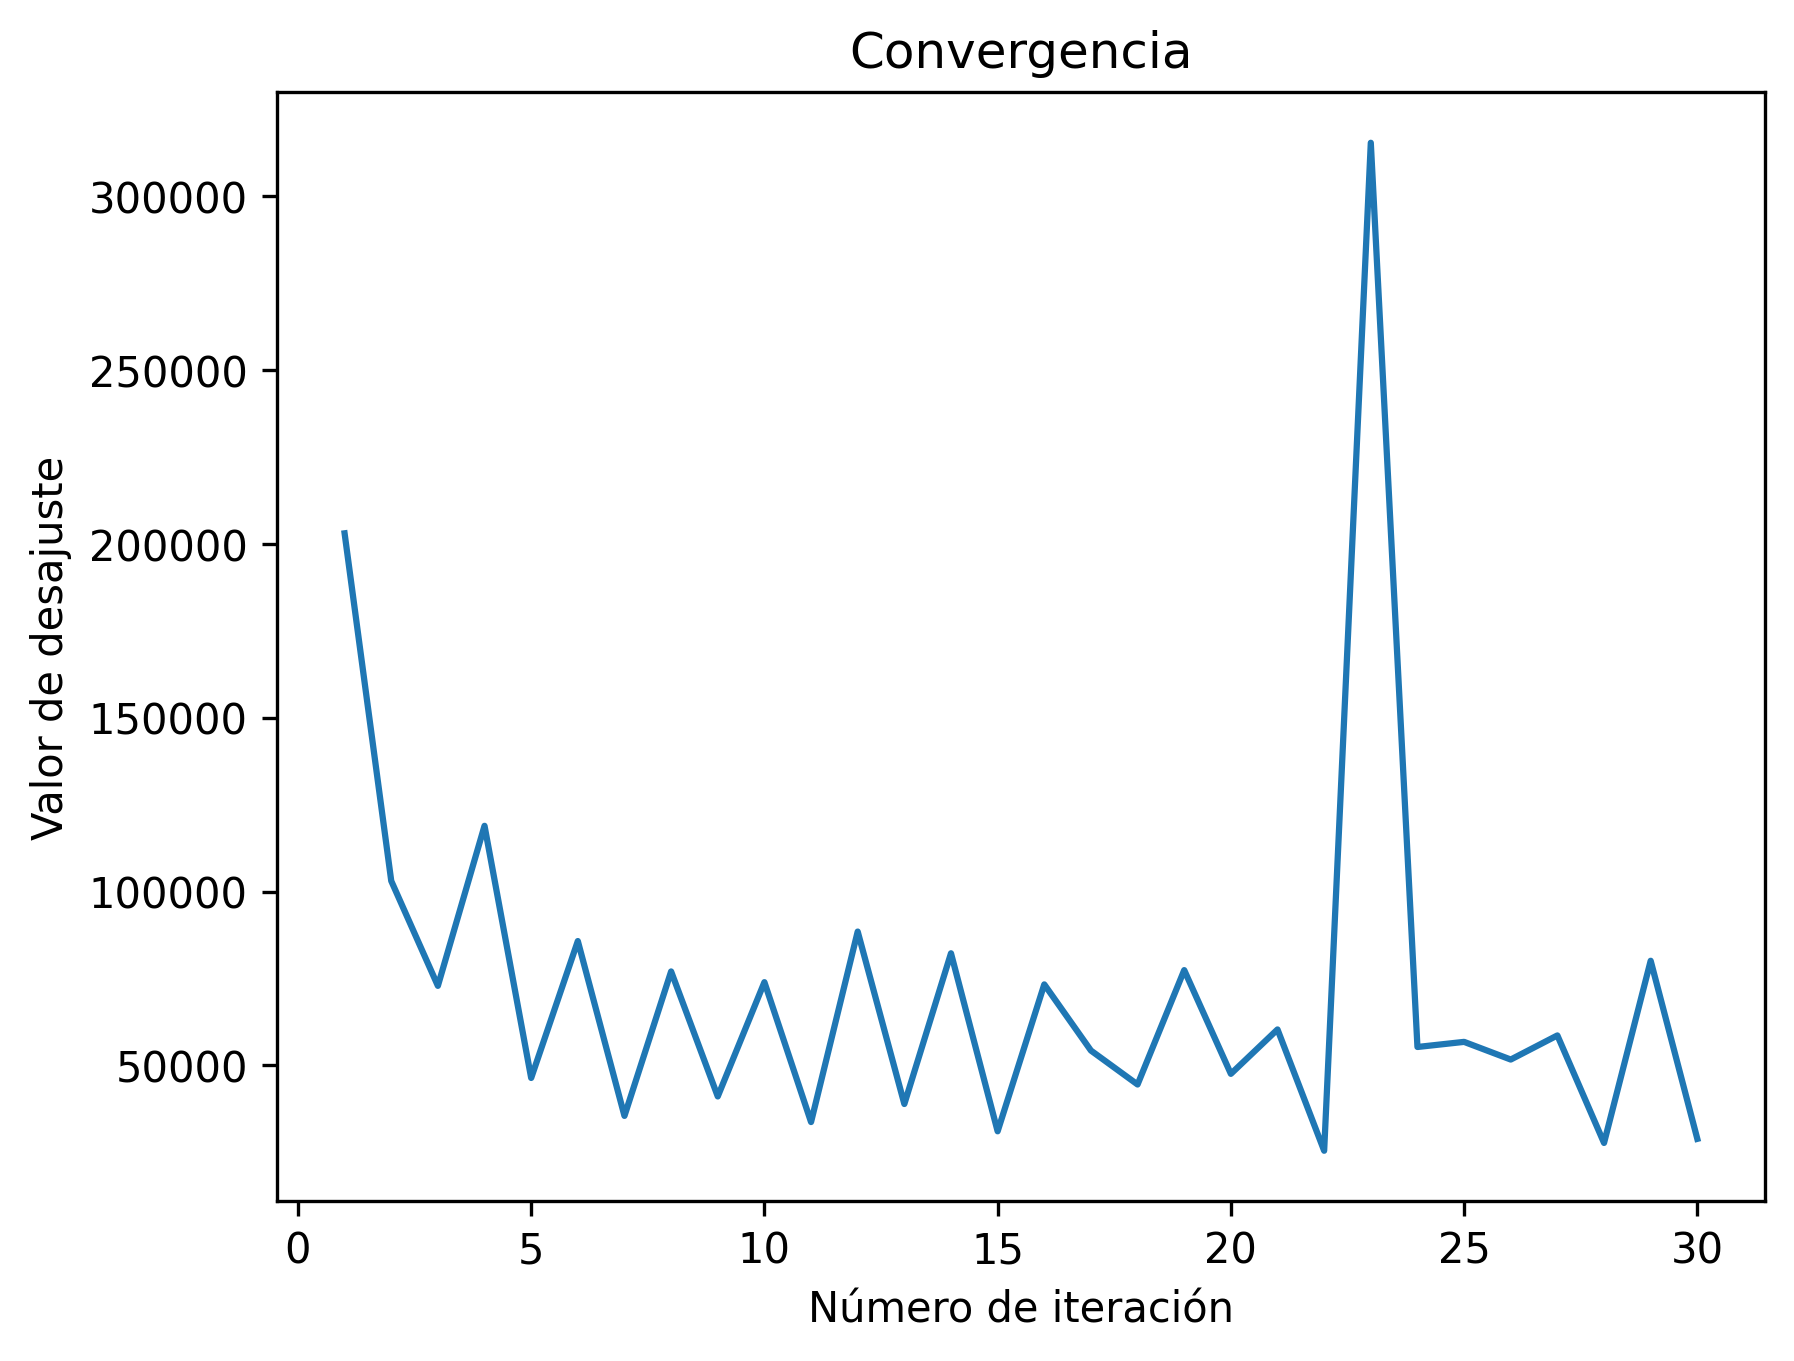

In [17]:
fig = figure(dpi=300)#dpi=300)
xax = 1:1:30
fvals = fval
fvals[1] = fval[2]+0.1f6
plot(xax,fvals)
#scatter(45,fval[45], color="black")
xlabel("Número de iteración")
ylabel("Valor de desajuste")
title("Convergencia")
display(fig)

In [19]:
minimum(fvals)

25414.607f0

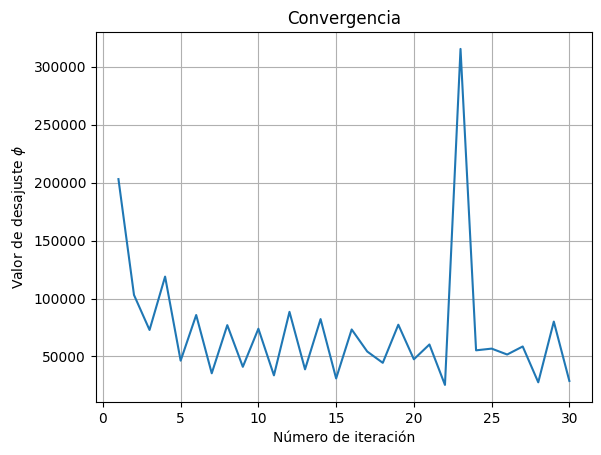

In [18]:
fig = figure()#dpi=300)
xax = 1:1:30
plot(xax,fvals)
#scatter(45,fval[45], color="black")
xlabel("Número de iteración")
ylabel(L"Valor de desajuste $\phi$")
title("Convergencia")
grid()
display(fig)

In [72]:
ruido = rtm50[200,:][1:50] + (randn(50) * 0.005);

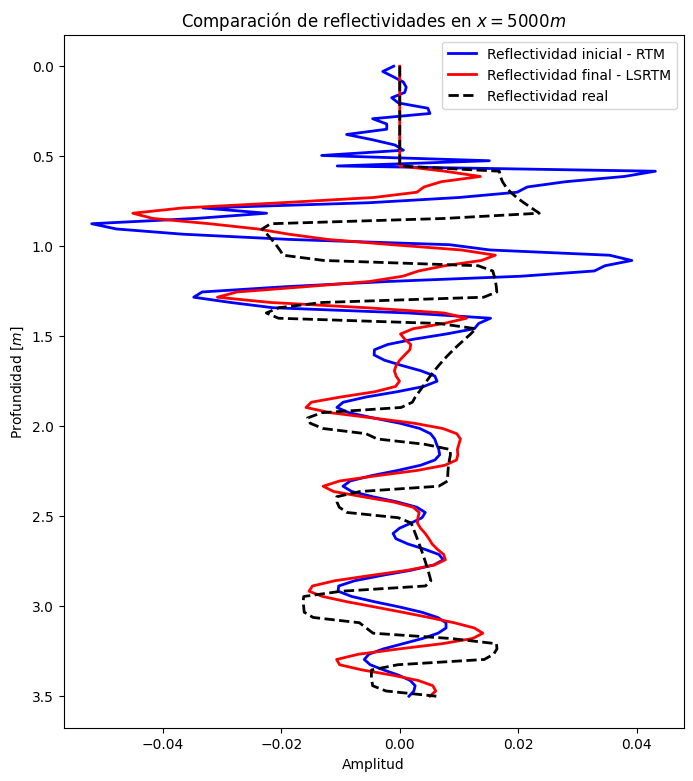

In [61]:
fig = figure(figsize=(8,9))#, dpi=300)
xax = range(0, stop=3.5, length=121)

dm_true=reshape(dm, (401,121));
rtm50=reshape(x_values[:, 2], (401,121)) # tomamos la primera iteracion
lsrtmf=reshape(x_values[:, 31], (401,121)) # tomamos la primera iteracion

# ruido
rtm_noisy = rtm50[200,:];
rtm_noisy[1:50] .+= (randn(50) * 0.005)
rtm_noisy .*= 1

plot(rtm_noisy, xax, linewidth=2, label="Reflectividad inicial - RTM", "b")
plot(x[200,:], xax, linewidth=2, label="Reflectividad final - LSRTM", "r")
plot(dm_true[200,:], xax, linewidth=2, label="Reflectividad real", "k--")
legend()
gca().invert_yaxis()
xlabel("Amplitud")
ylabel(L"Profundidad $[m]$")
title(L"Comparación de reflectividades en $x=5000m$")
display(fig)

In [36]:
minimum(dm_true[200,:])

-0.023259155f0

In [37]:
maximum(dm_true[200,:])

0.023568392f0

In [63]:
rtm_norm=(rtm_noisy .- minimum(rtm_noisy)) ./ (maximum(rtm_noisy) .- minimum(rtm_noisy)) .* 2 .- 1; 
x_norm=reshape((x_values[:, 31] .- minimum(x_values[:, 31])) ./ (maximum(x_values[:, 31]) .- minimum(x_values[:, 31])) .* 2 .- 1, (401,121));
dm_true_norm=reshape((dm .- minimum(dm)) ./ (maximum(dm) .- minimum(dm)) .* 2 .- 1, (401,121));

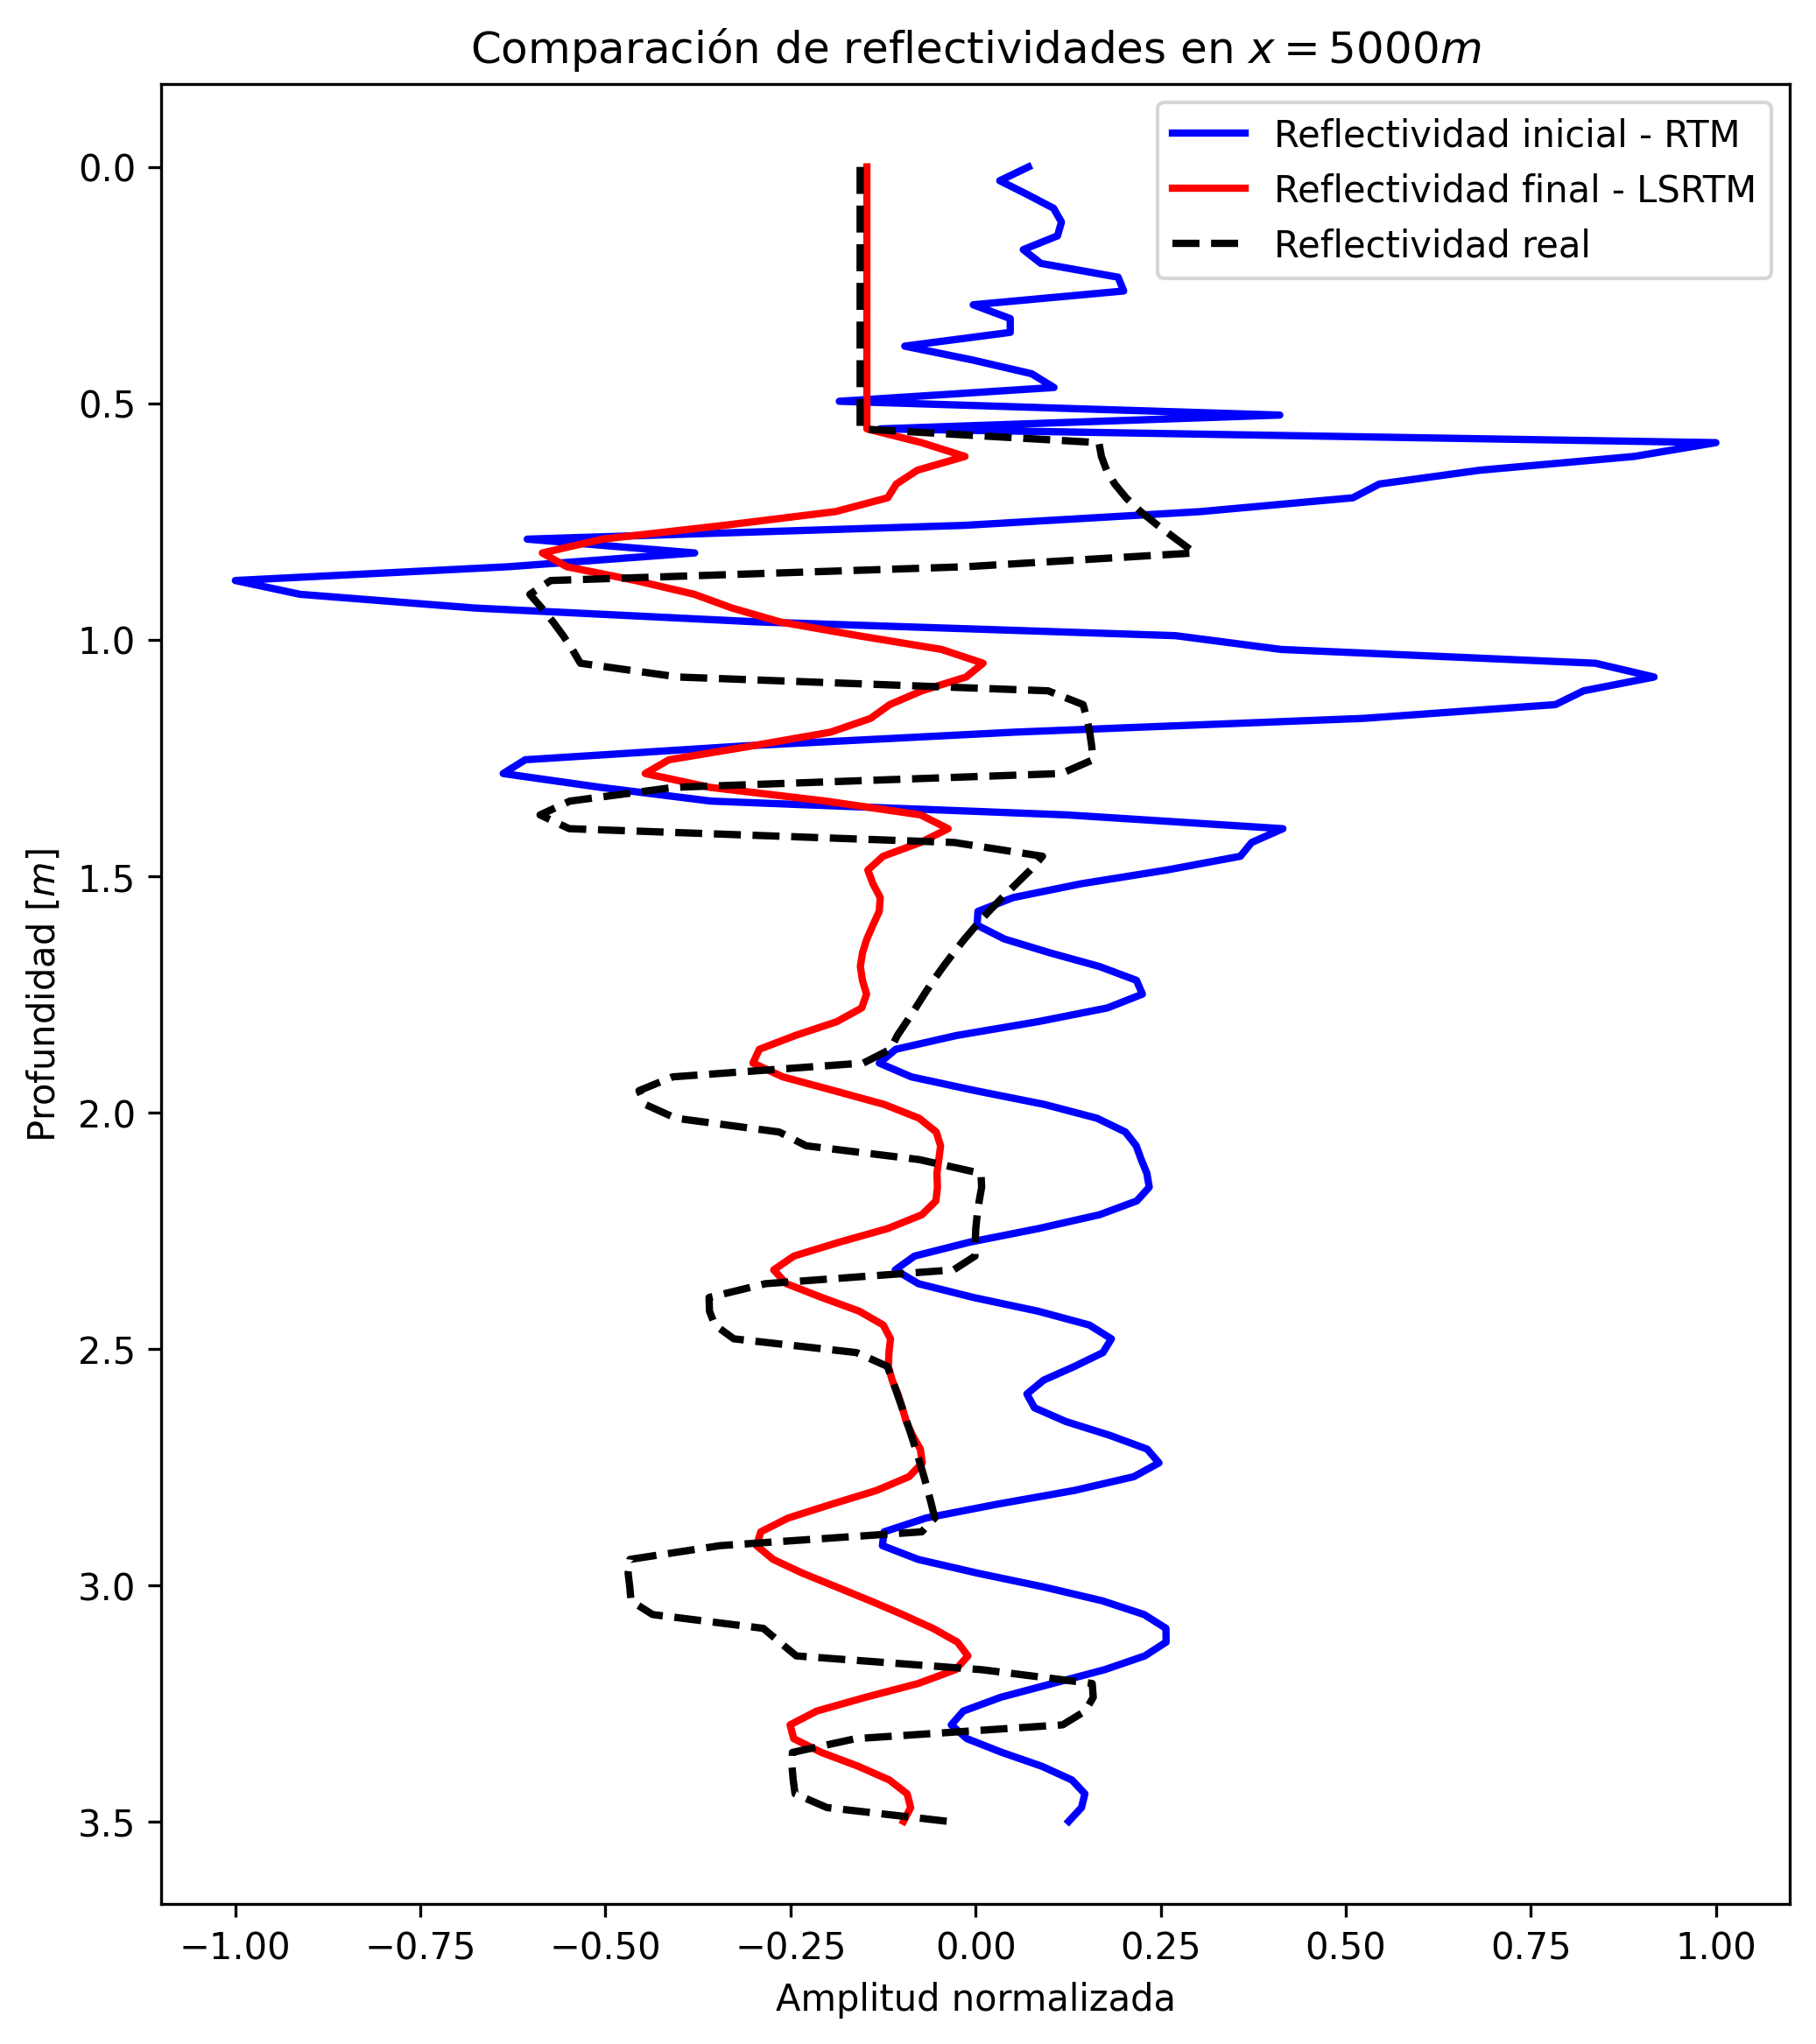

In [71]:
fig = figure(figsize=(8,9), dpi=300)#, dpi=300)
xax = range(0, stop=3.5, length=121)
plot(rtm_norm, xax, linewidth=2, label="Reflectividad inicial - RTM", "b")
plot(x_norm[200,:].+0.2, xax, linewidth=2, label="Reflectividad final - LSRTM", "r")
plot(dm_true_norm[200,:], xax, linewidth=2, label="Reflectividad real", "k--")
legend()
gca().invert_yaxis()
xlabel("Amplitud normalizada")
ylabel(L"Profundidad $[m]$")
title(L"Comparación de reflectividades en $x=5000m$")
display(fig)

In [100]:
model0.d

(25.0f0, 25.0f0)

In [19]:
#save("model_custom_fwi_result_low_f.jld", "n", M["n"], "d", M["d"], "o", M["o"], "m", M["m"], "m0", ((1f0 ./ fwi).^2), "dm", dm)

In [17]:
canonicalize(t2 - t1)

17 minutes, 56 seconds, 921 milliseconds

In [18]:
(t2 - t1)

1076921 milliseconds

In [75]:
writedlm("lsrtm_results/rtm.txt", rtm.data)
writedlm("lsrtm_results/lsrtm.txt", x_values)
writedlm("lsrtm_results/dmtrue.txt", dm_)
writedlm("lsrtm_results/fval.txt", fval)